# Machine Learning Analysis - London Housing Data

This notebook will apply supervised ML models from scikit-learn to analyse the real estate data in ```10m_london_houses_.csv```.

## Plan
Split into 3 sections by the data used: SQM-only, all data and top features
- SQM-only: get data, run simple models, plot predictions and show R2 for some cross-validation folds (no HP tuning)
- All data: go into more detail and do HP tuning
    - Prepare data: convert categoric to dummy variables, scale data
    - Create simple models and plot results
    - HP tune the models via RandomizedSearchCV
    - Evaluate the models using R2, RMSE (NMSE?), MAE and MAPE
- Top features: compare the performance of models using just the top features with the last models
    - Run PCA - determine the top third of features
    - Train models on just these features
    - HP tune these models via RandomizedSearchCV
    - Evaluate the models using R2, RMSE (NMSE?), MAE and MAPE
- Conlusion
    - How good are the models?
    - What have we learned?
    - Any key takeaways

Repository link: [Github](https://github.com/rsamconn/London-housing)

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge

print(np.NaN)

nan


In [2]:
# Load the data
housing_df = pd.read_csv('data/10m_london_houses_.csv')

# Reminder of how the data looks
print(f"Dataset shape: {housing_df.shape}")
display(housing_df.head())

Dataset shape: (1000, 17)


,Address,Neighborhood,Bedrooms,Bathrooms,Square Meters,Building Age,Garden,Garage,Floors,Property Type,Heating Type,Balcony,Interior Style,View,Materials,Building Status,Price (£)
0,78 Regent Street,Notting Hill,2,3,179,72,No,No,3,Semi-Detached,Electric Heating,High-level Balcony,Industrial,Garden,Marble,Renovated,2291200
1,198 Oxford Street,Westminster,2,1,123,34,Yes,No,1,Apartment,Central Heating,High-level Balcony,Industrial,City,Laminate Flooring,Old,1476000
2,18 Regent Street,Soho,5,3,168,38,No,Yes,3,Semi-Detached,Central Heating,No Balcony,Industrial,Street,Wood,Renovated,1881600
3,39 Piccadilly Circus,Islington,5,1,237,53,Yes,Yes,1,Apartment,Underfloor Heating,No Balcony,Classic,Park,Granite,Renovated,1896000
4,116 Fleet Street,Marylebone,4,1,127,23,No,Yes,2,Semi-Detached,Central Heating,No Balcony,Modern,Park,Wood,Old,1524000


Our data has 1000 rows and 17 columns: 6 columns of numeric data and 11 with categoric data. You can find a thorough analysis of them in the EDA notebook.

First, let's set aside 100 rows to be used for validating the model outputs later.

In [4]:
# Get last 100 rows of the housing_df
housing_validation_df = housing_df.tail(100)
housing_train_test_df = housing_df.head(900)

The first 900 rows will be used for training and testing.

## Attempt 1 - only look at house area
It's often mentioned that the most important factor in determining house prices is the size.

Let's take a look at that idea by building a model that only uses the Square Meters data as a feature.

First, we get our feature and target data and split it into test and training set.

In [6]:
# Create Square Meters only dataset from the training/testing data
X_sqm = housing_train_test_df['Square Meters'].values.reshape(-1, 1) # Feature matrix
y = housing_train_test_df['Price (£)'].values # Target vector
X_train_sqm, X_test_sqm, y_train_sqm, y_test_sqm = train_test_split(X_sqm, y, test_size=0.3, random_state=24)

print(X_train_sqm.shape, X_test_sqm.shape, y_train_sqm.shape, y_test_sqm.shape)

(630, 1) (270, 1) (630,) (270,)


Next, we instantiate and fit our models

In [7]:
# Instantiate models
linreg_sqm = LinearRegression()
lasso_sqm = Lasso(alpha = 0.1)
ridge_sqm = Ridge(alpha = 0.1)

# Fit to numeric data
linreg_sqm.fit(X_train_sqm, y_train_sqm)
lasso_sqm.fit(X_train_sqm, y_train_sqm)
ridge_sqm.fit(X_train_sqm, y_train_sqm)

# Save models to a dictionary
models_sqm = {
    'Linear Regression (SQM)': linreg_sqm,
    'Lasso Regression (SQM)': lasso_sqm,
    'Ridge Regression (SQM)': ridge_sqm
}

Now we can visualise their predictions and do some simple testing.

Since we'll want to this visualization again later, let's create a function for it.

In [8]:
def score_predict_plot(model_dict, X_train, y_train, X_test, y_test, X_test1D, title='Model predictions'):
    """Evaluate multiple models and plot their predictions vs actual values."""
    
    # Create figure and plot the actual results
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test1D, y_test, label='Actual', color='black', alpha=0.9, s=20)
    
    # Loop over models
    for model_name, model in model_dict.items():
        # Predict and plot
        y_pred = model.predict(X_test)
        plt.scatter(X_test1D, y_pred, label=model_name, alpha=0.5, s=20)
        # Calculate and print R² scores
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
        print(f"{model_name} training--testing R²: {train_score:.4f}--{test_score:.4f}")
        
    plt.xlabel('Square meters [m^2]', fontsize=11)
    plt.ylabel('Price [£]', fontsize=11)
    plt.title(title, fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


Linear Regression (SQM) training--testing R²: 0.6383--0.6029
Lasso Regression (SQM) training--testing R²: 0.6383--0.6029
Ridge Regression (SQM) training--testing R²: 0.6383--0.6029


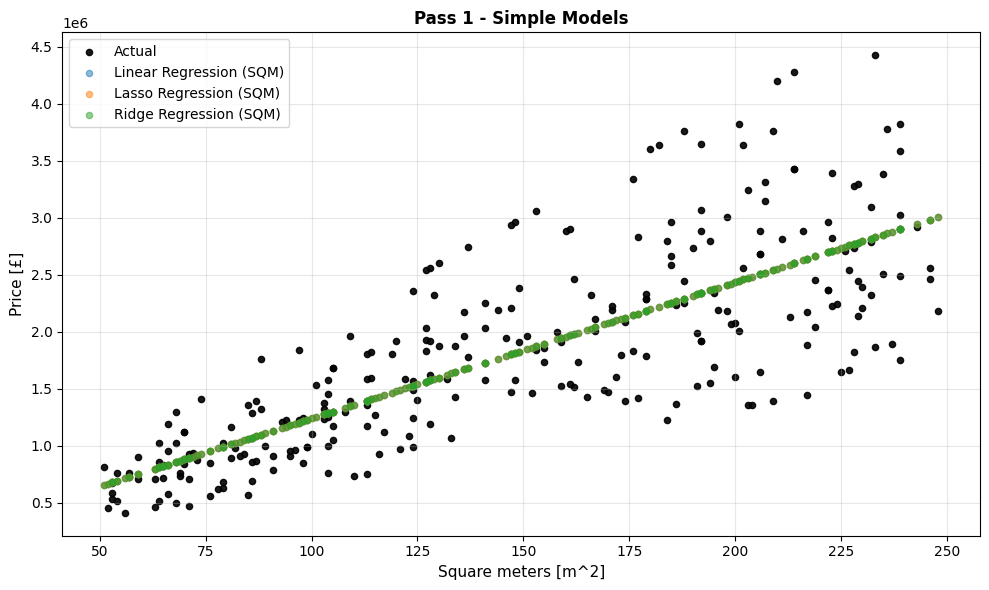

In [9]:
score_predict_plot(models_sqm,
                   X_train_sqm, y_train_sqm, X_test_sqm, y_test_sqm, X_test_sqm,
                   title='Pass 1 - Simple Models')

We can see the models have drawn a straight line through the data, as linear regression models are designed to do.

The models' $R^2$ scores of around 0.6 means they explain 60% of the variance in the data.

Let's go slightly deeper on the performance with some cross validation.

In [33]:
from sklearn.model_selection import KFold, cross_val_score
kf20 = KFold(n_splits=10, shuffle=True, random_state=23)

for model_name, model in models_sqm.items():
    cv_scores_sqm_train = cross_val_score(model, X_train_sqm, y_train_sqm, cv=kf20, scoring='r2')
    print(f'{model_name} cross-validation scores: min--mean--max (std.)')
    print(f'{np.min(cv_scores_sqm_train):.3f} --- {np.mean(cv_scores_sqm_train):.3f} --- {np.max(cv_scores_sqm_train):.3f} ({cv_scores_sqm_train.std():.3f})')

for model_name, model in models_sqm.items():
    cv_scores_sqm_test = cross_val_score(model, X_test_sqm, y_test_sqm, cv=kf20, scoring='r2')
    print(f'{model_name} cross-validation scores: min--mean--max (std.)')
    print(f'{np.min(cv_scores_sqm_test):.3f} --- {np.mean(cv_scores_sqm_test):.3f} --- {np.max(cv_scores_sqm_test):.3f} ({cv_scores_sqm_test.std():.3f})')

Linear Regression (SQM) cross-validation scores: min--mean--max (std.)
0.522 --- 0.629 --- 0.698 (0.052)
Lasso Regression (SQM) cross-validation scores: min--mean--max (std.)
0.522 --- 0.629 --- 0.698 (0.052)
Ridge Regression (SQM) cross-validation scores: min--mean--max (std.)
0.522 --- 0.629 --- 0.698 (0.052)
Linear Regression (SQM) cross-validation scores: min--mean--max (std.)
0.210 --- 0.578 --- 0.710 (0.135)
Lasso Regression (SQM) cross-validation scores: min--mean--max (std.)
0.210 --- 0.578 --- 0.710 (0.135)
Ridge Regression (SQM) cross-validation scores: min--mean--max (std.)
0.210 --- 0.578 --- 0.710 (0.135)


After checking the model scores across 20 different cross validation folds, we see the $R^2$ can go pretty low, but in general it's around 0.5-0.7 - not great, but not bad for a single feature.

Interestingly, the models all produce idental results and scores.

Let's make some models that take advantage of all of the data.

## Attempt 2 - use all data
Let's now see how well the models can do with all the data available.

First, we need to clean it up in a few ways:
- Drop the 'Address' column, since most values are unique and this would blow up our feature set.
- Encode categorical data using Pandas' ```get_dummies()``` function.
- Convert the resulting data into numerical format.

In [ ]:
# Check how many unique values are in the addresses column of the housing_train_test_df
print(f'Unique addresses: {housing_train_test_df["Address"].nunique()}')

# Drop the Address column, apply get_dummies to the remaining categorical columns
housing_train_test_df_encoded = pd.get_dummies(
    housing_train_test_df.drop(columns=['Address']), drop_first=True
).astype(np.float32)

housing_train_test_df_encoded.shape

Unique addresses: 710


(900, 36)

Now we split into testing and training data again.

In [57]:
X_all = housing_train_test_df_encoded.drop(columns=['Price (£)']).values
y_all = housing_train_test_df_encoded['Price (£)'].values
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.3, random_state=24)

print(X_train_all.shape, X_test_all.shape, y_train_all.shape, y_test_all.shape)

(630, 35) (270, 35) (630,) (270,)


We also want to scale the data, which we'll do using a pipeline.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a pipeline with scaling and linear regression
pipeline_linreg = Pipeline([('scaler', StandardScaler()),
                            ('linreg', LinearRegression())])
# Create a pipeline with scaling and lasso and ridge regression
pipeline_lasso = Pipeline([('scaler', StandardScaler()),
                           ('lasso', Lasso(alpha=0.1))])
pipeline_ridge = Pipeline([('scaler', StandardScaler()),
                           ('ridge', Ridge(alpha=0.1))])